# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-20 20:13:01.652415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-20 20:13:25.089025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 20:13:35.802888: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2025-09-20 20:14:12.362989: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



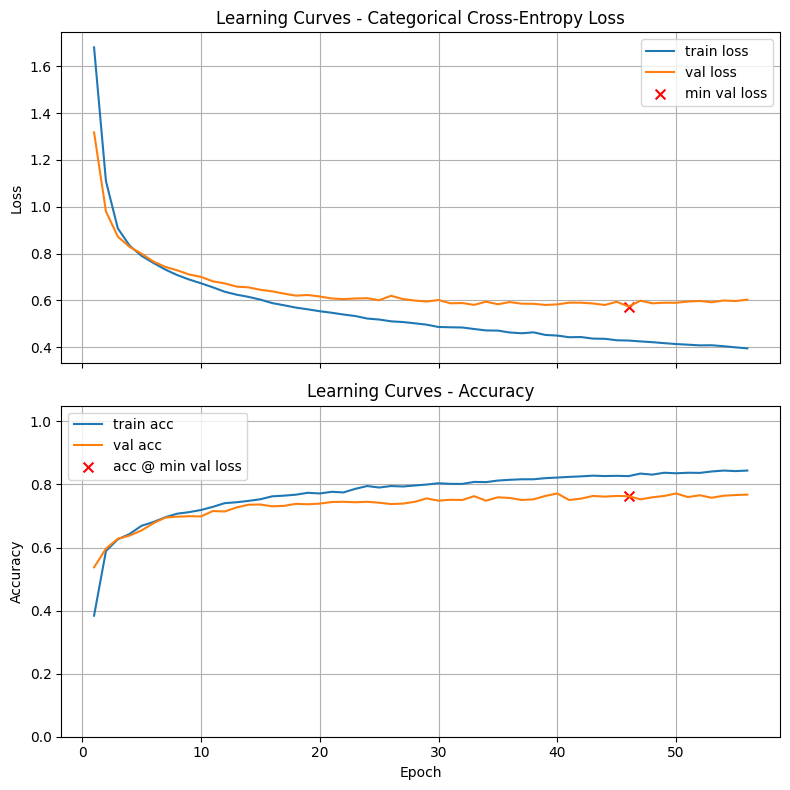

Final Training Loss:            0.3951
Final Training Accuracy:        0.8440
Final Validation Loss:          0.6033
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5740 (Epoch 46)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.5772
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:12

Learning Curves



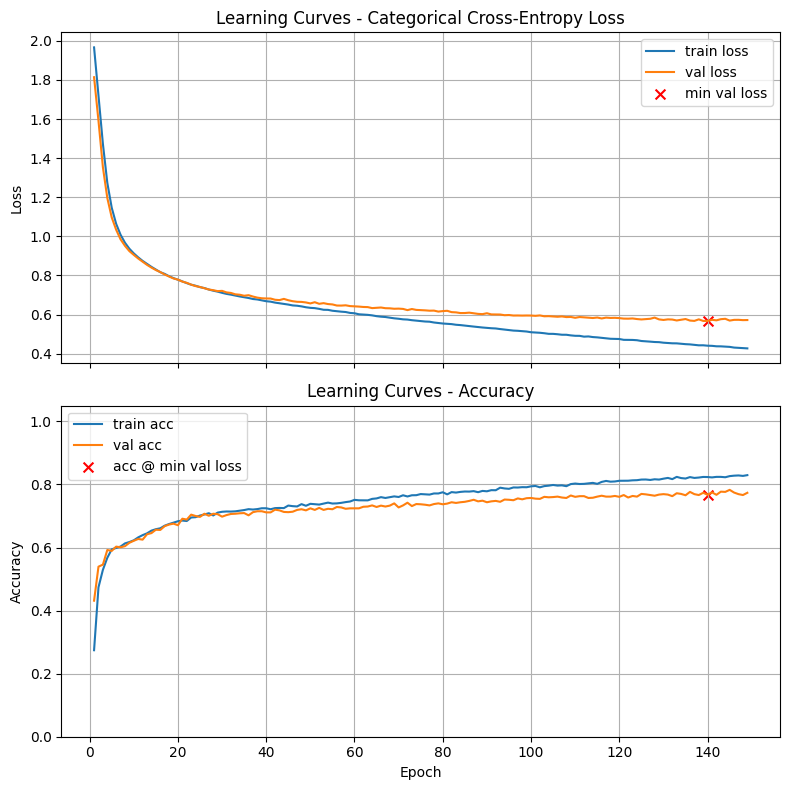

Final Training Loss:            0.4268
Final Training Accuracy:        0.8295
Final Validation Loss:          0.5717
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.5671 (Epoch 140)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.5770
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:28

Learning Curves



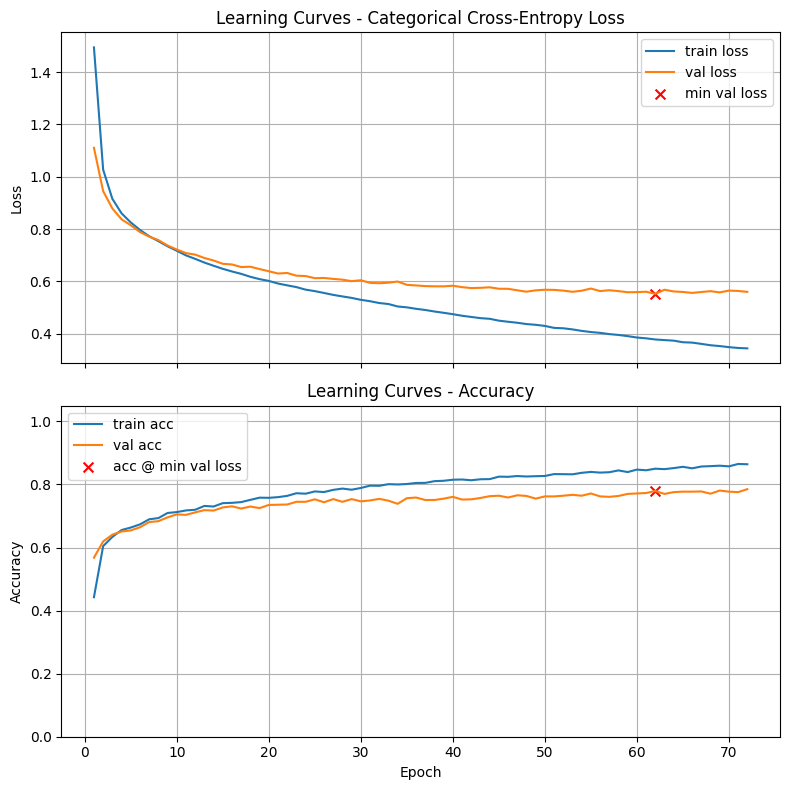

Final Training Loss:            0.3440
Final Training Accuracy:        0.8640
Final Validation Loss:          0.5600
Final Validation Accuracy:      0.7850
Minimum Validation Loss:        0.5523 (Epoch 62)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5621
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:14


In [10]:
# Problem 1 — Activation sweep (sets a1a, a1b)
import numpy as np

# ensure dict for train_and_test side effects
try: results
except NameError: results = {}
if isinstance(results, list): results = {}

codes = {"relu":0, "sigmoid":1, "tanh":2}
best = {"val": -1.0, "code": None, "model": None}

for act in ["relu","sigmoid","tanh"]:
    m = build_model(X_train.shape[1], [(64,act,0.0,0.0),(32,act,0.0,0.0)], n_classes)
    H = train_and_test(m, use_early_stopping=True, patience=10, verbose=0, return_history=True)
    hist = getattr(H, "history", H) or {}
    vl = np.array(hist.get("val_loss", []))
    i  = int(vl.argmin()) if vl.size else None
    va = hist.get("val_accuracy", hist.get("val_acc", [])) or []
    val = float(va[i]) if (i is not None and len(va)>i) else float(m.evaluate(X_val, y_val, verbose=0)[1])
    if val > best["val"]:
        best = {"val": val, "code": codes[act], "model": m}

model_baseline = best["model"]


### Graded Questions

In [11]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = int(best["code"])           # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [13]:
# Set a1b to the validation accuracy found by this best activation function

a1b = float(best["val"])          # Replace 0.0 with your answer

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7793


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



LR=0.001



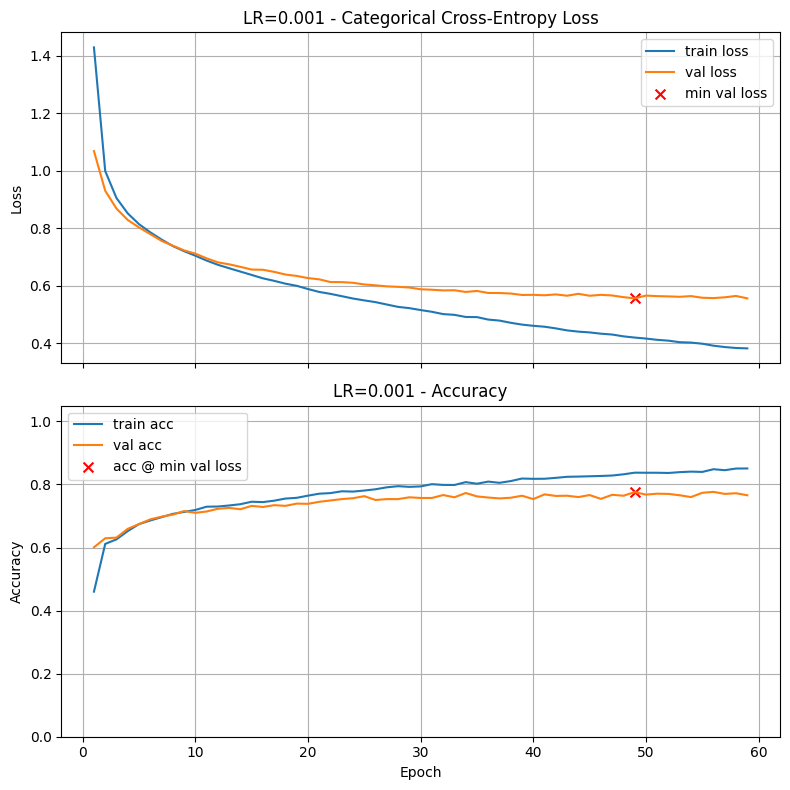

Final Training Loss:            0.3823
Final Training Accuracy:        0.8507
Final Validation Loss:          0.5563
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5563 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5885
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:11

LR=0.0005



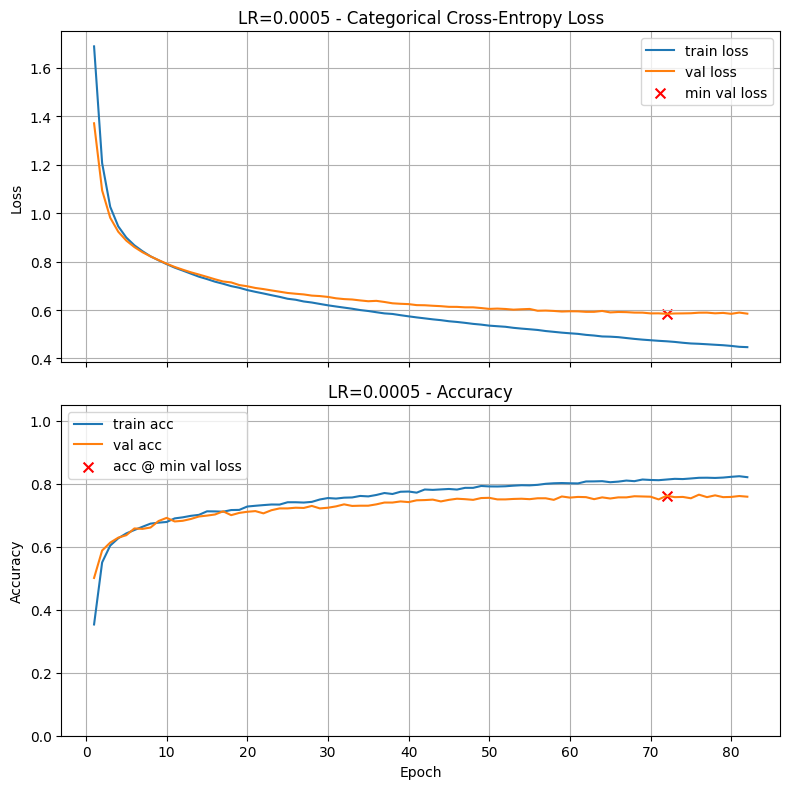

Final Training Loss:            0.4467
Final Training Accuracy:        0.8205
Final Validation Loss:          0.5850
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.5843 (Epoch 72)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6020
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:14

LR=0.0001



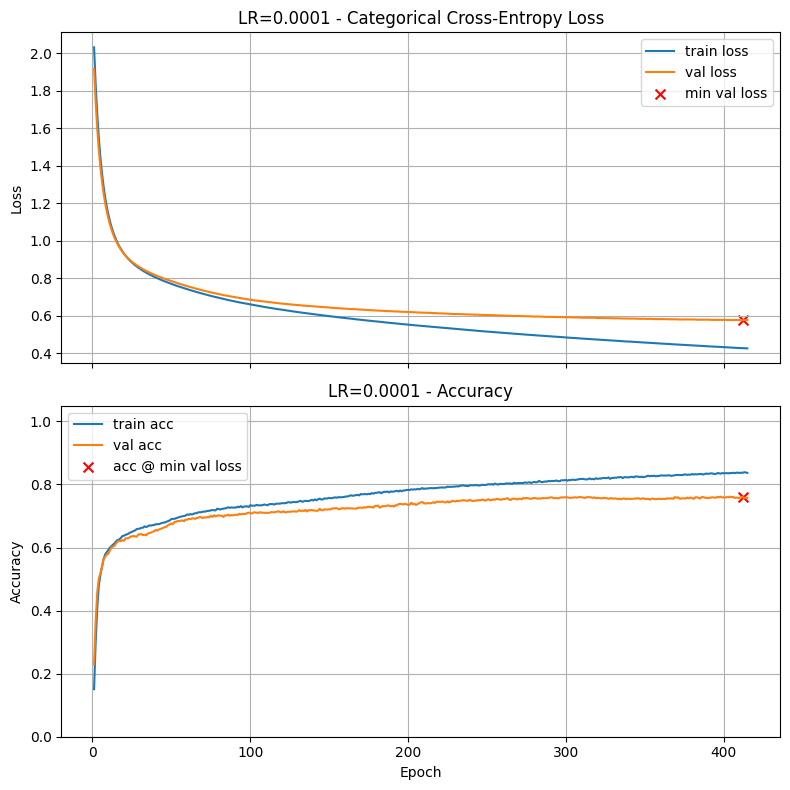

Final Training Loss:            0.4258
Final Training Accuracy:        0.8367
Final Validation Loss:          0.5775
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.5763 (Epoch 412)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.5853
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:01:04

LR=5e-05



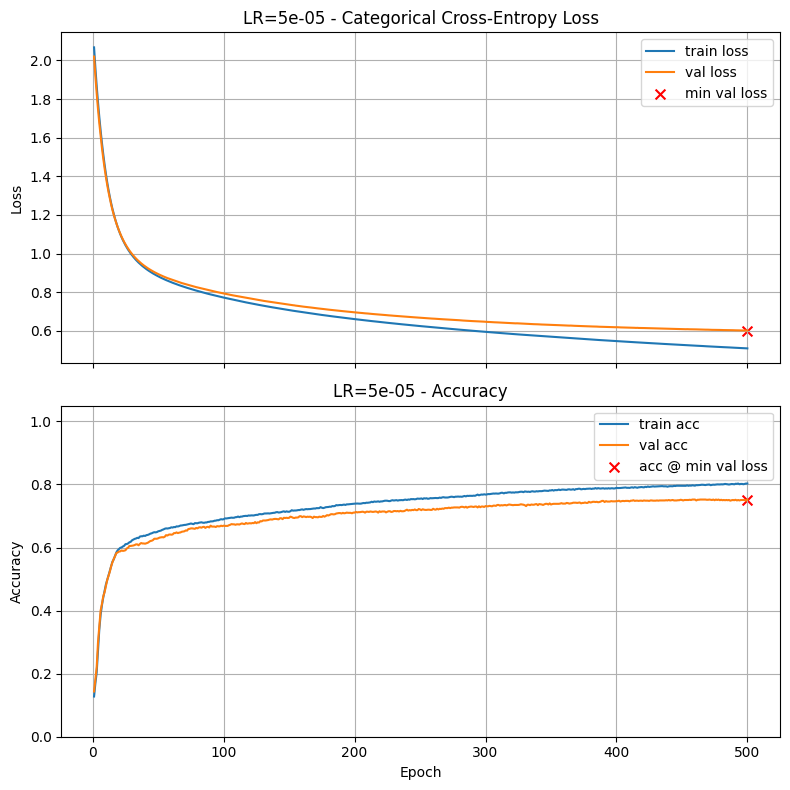

Final Training Loss:            0.5088
Final Training Accuracy:        0.8029
Final Validation Loss:          0.6012
Final Validation Accuracy:      0.7514
Minimum Validation Loss:        0.6012 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.6195
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:01:17

LR=1e-05



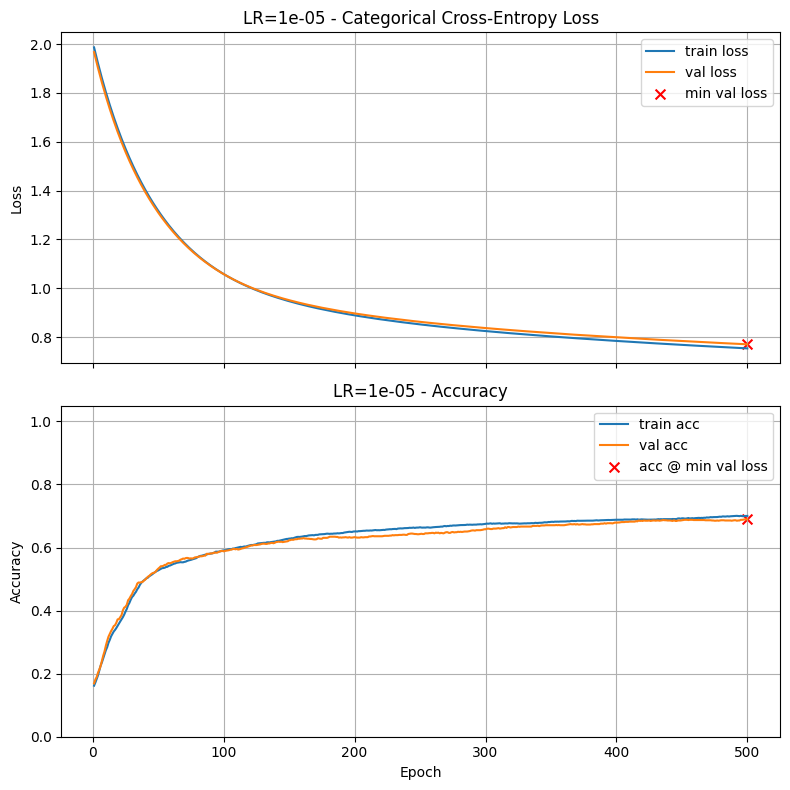

Final Training Loss:            0.7535
Final Training Accuracy:        0.7002
Final Validation Loss:          0.7702
Final Validation Accuracy:      0.6893
Minimum Validation Loss:        0.7702 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6893

Test Loss: 0.7813
Test Accuracy: 0.6964

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:01:17


In [15]:
# Problem 2 — Learning-rate sweep (sets a2a, a2b)
import numpy as np

# ensure dict for train_and_test side effects
try: results
except NameError: results = {}
if isinstance(results, list): results = {}

act = {0:'relu',1:'sigmoid',2:'tanh'}.get(a1a,'relu')
lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

val_accs = []
for lr in lrs:
    m = build_model(X_train.shape[1], [(64,act,0.0,0.0),(32,act,0.0,0.0)], n_classes)
    H = train_and_test(m, epochs=500, lr_schedule=lr, use_early_stopping=True,
                       patience=10, verbose=0, return_history=True, title=f"LR={lr:g}")
    hist = getattr(H,'history',H) or {}
    vl = np.array(hist.get('val_loss', []))
    i  = int(vl.argmin()) if vl.size else None
    va = hist.get('val_accuracy', hist.get('val_acc', [])) or []
    val_accs.append(float(va[i]) if (i is not None and len(va)>i)
                    else float(m.evaluate(X_val, y_val, verbose=0)[1]))

best_idx = int(np.nanargmax(val_accs))

#### Graded Questions

In [16]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = best_idx           # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000000


In [18]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = float(val_accs[best_idx])             # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7757


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



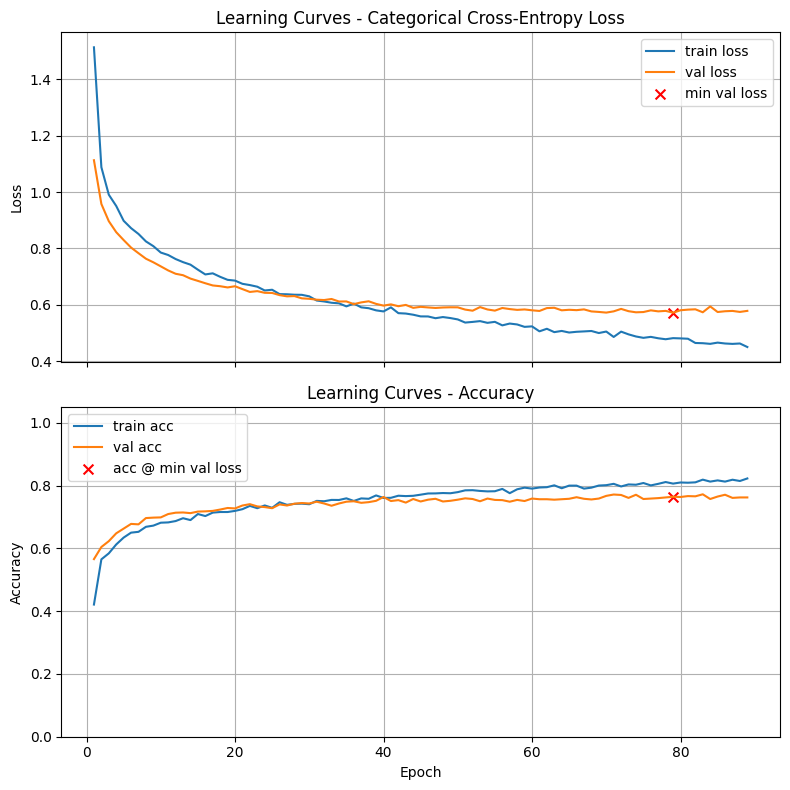

Final Training Loss:            0.4500
Final Training Accuracy:        0.8226
Final Validation Loss:          0.5783
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5718 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.5892
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:16

Learning Curves



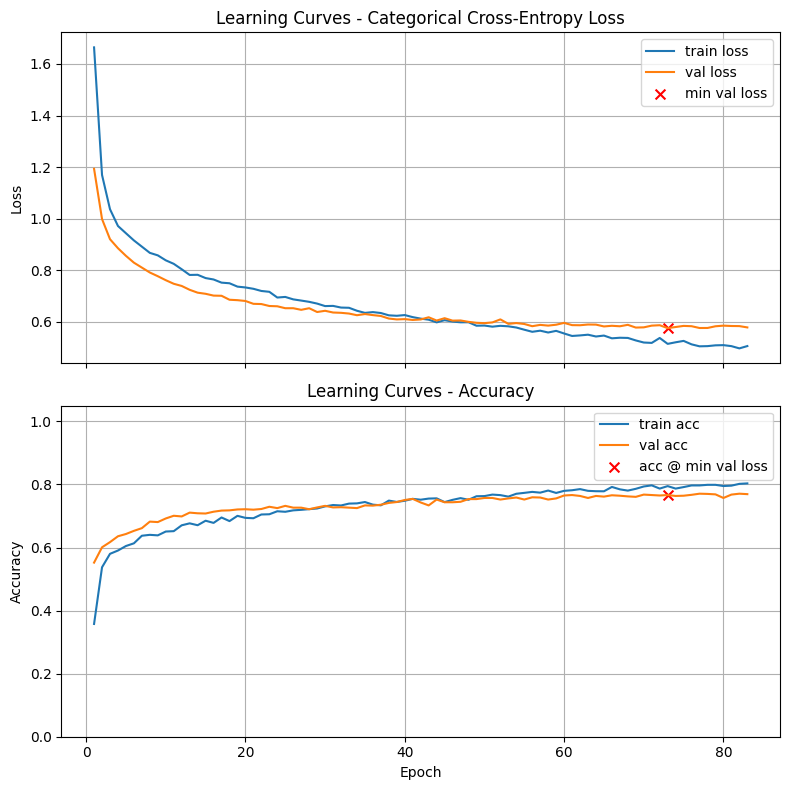

Final Training Loss:            0.5056
Final Training Accuracy:        0.8033
Final Validation Loss:          0.5780
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5752 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6022
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:15

Learning Curves



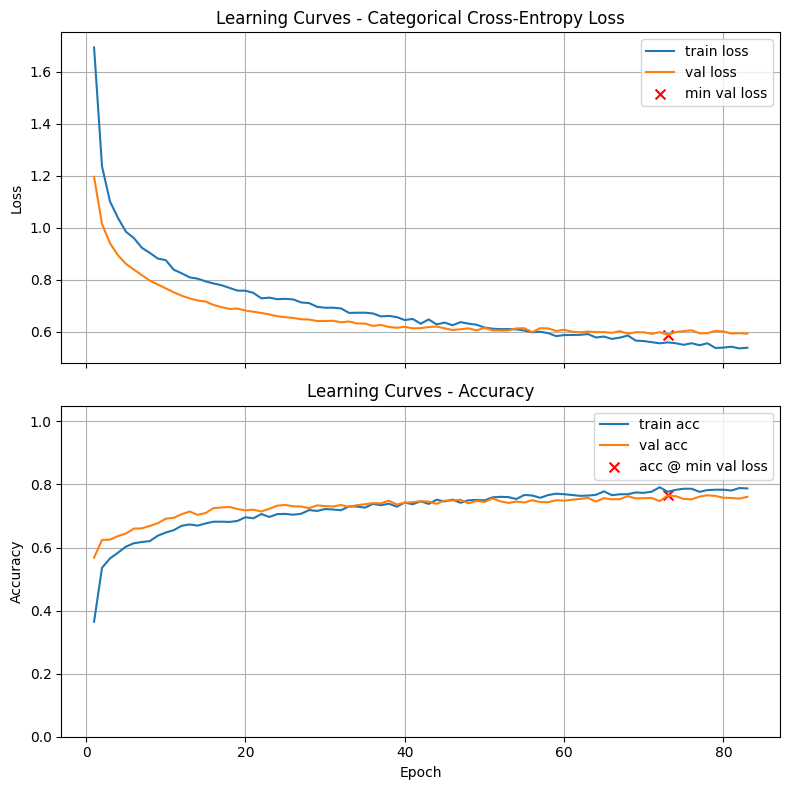

Final Training Loss:            0.5381
Final Training Accuracy:        0.7874
Final Validation Loss:          0.5920
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.5882 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6206
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:15

Learning Curves



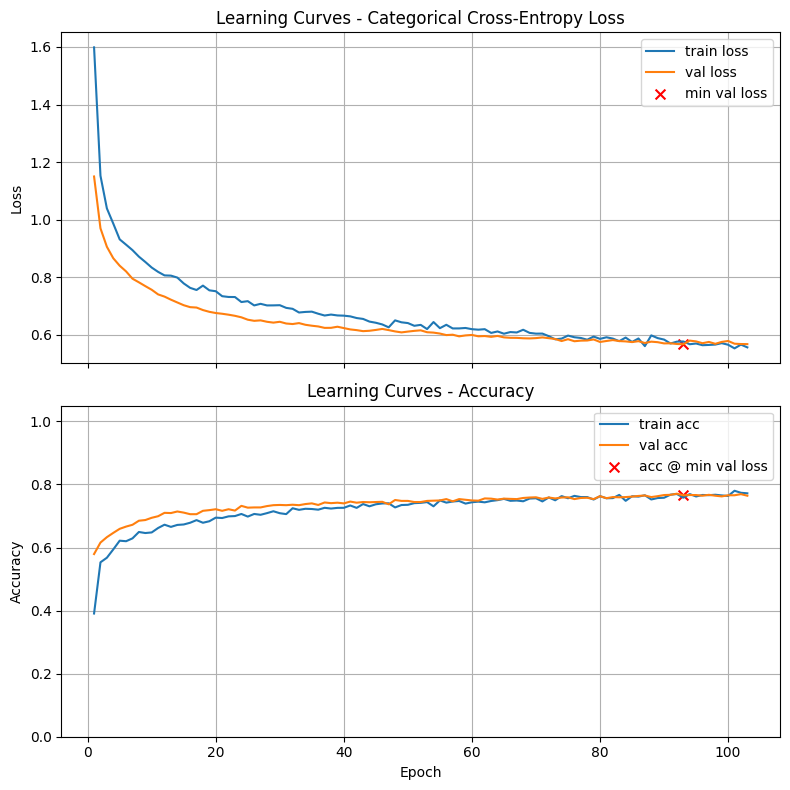

Final Training Loss:            0.5570
Final Training Accuracy:        0.7719
Final Validation Loss:          0.5683
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5678 (Epoch 93)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6035
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:18

Learning Curves



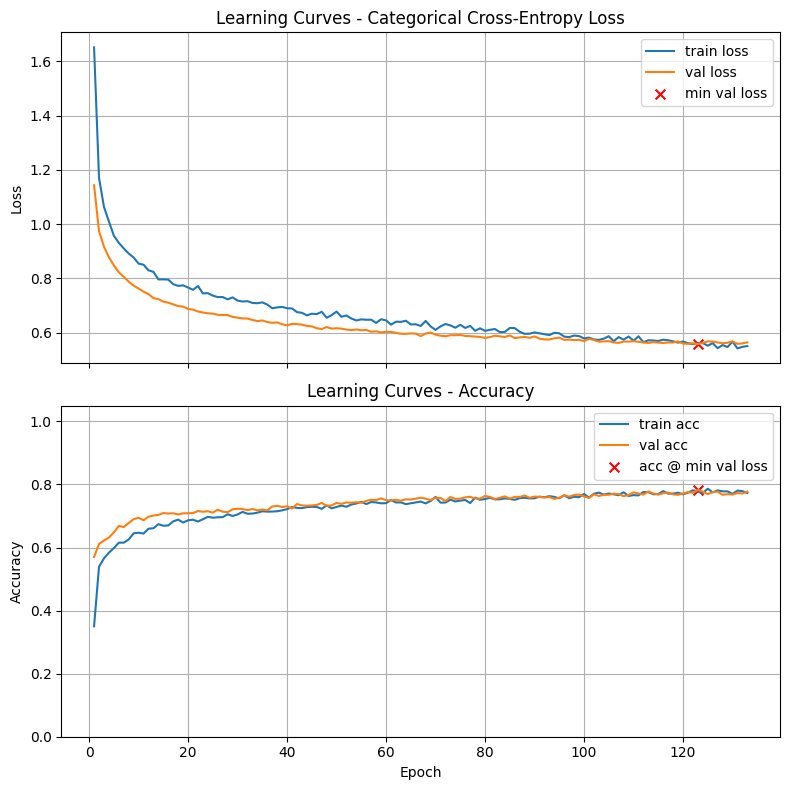

Final Training Loss:            0.5508
Final Training Accuracy:        0.7731
Final Validation Loss:          0.5643
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5577 (Epoch 123)
Validation Accuracy @ Min Loss: 0.7829

Test Loss: 0.5945
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:23

Learning Curves



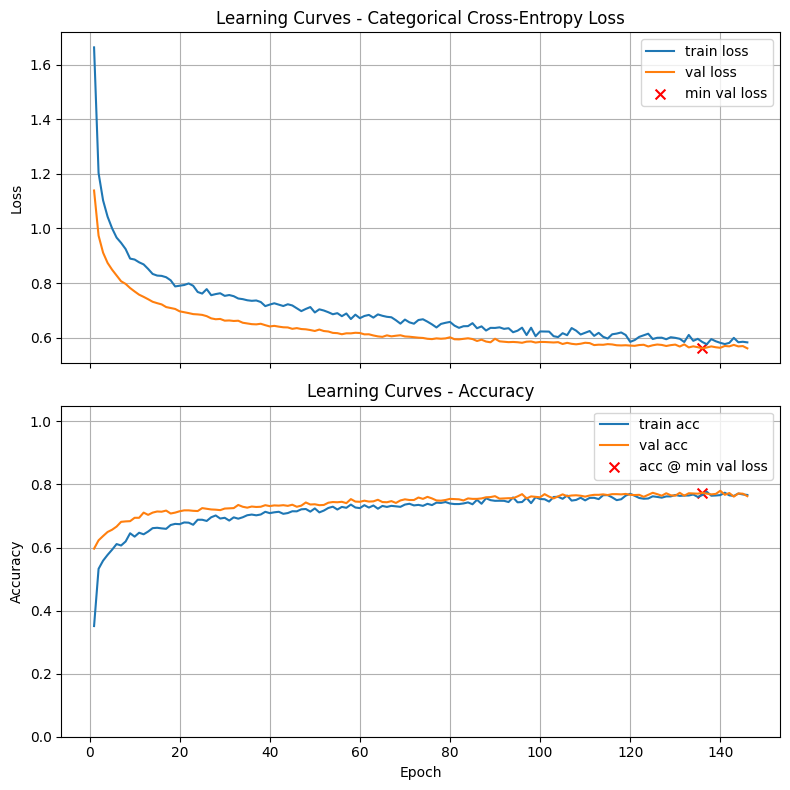

Final Training Loss:            0.5827
Final Training Accuracy:        0.7667
Final Validation Loss:          0.5608
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5606 (Epoch 136)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.6002
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:25

Learning Curves



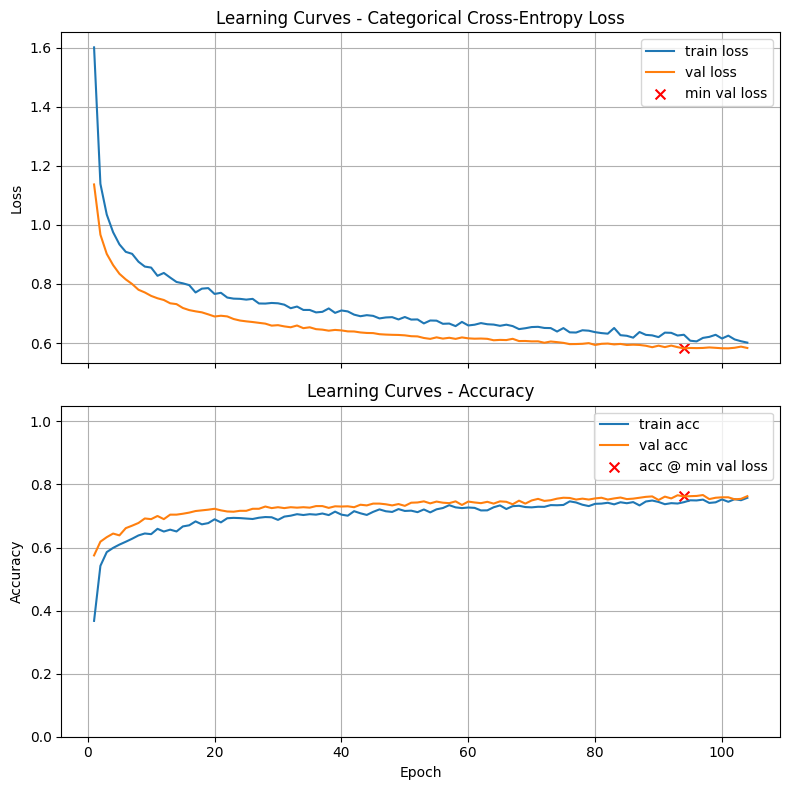

Final Training Loss:            0.6013
Final Training Accuracy:        0.7576
Final Validation Loss:          0.5832
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5818 (Epoch 94)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.6231
Test Accuracy: 0.7343

Validation-Test Gap (accuracy): 0.027857

Execution Time: 00:00:19

Learning Curves



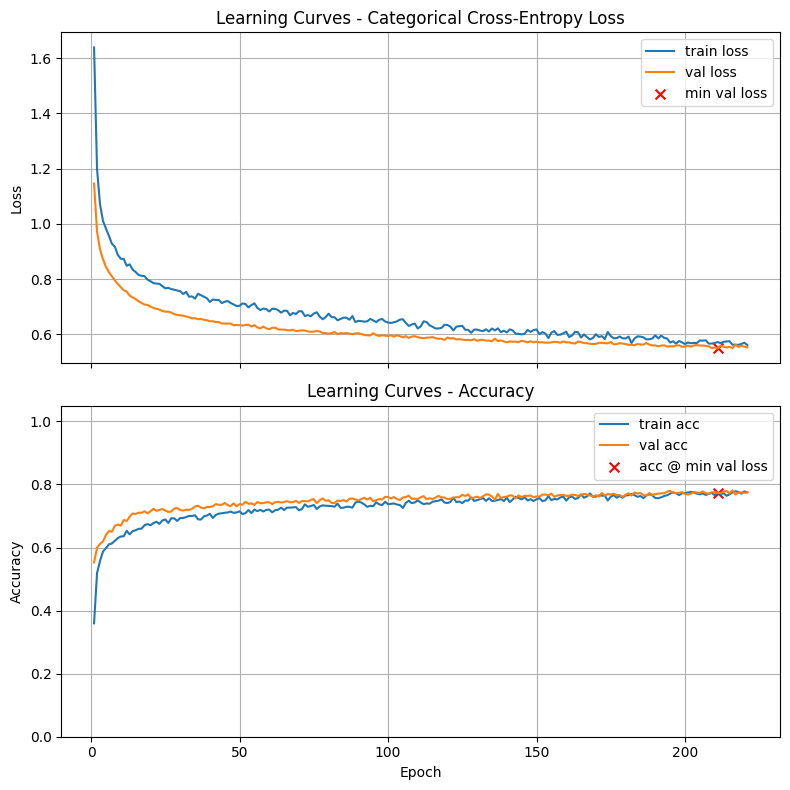

Final Training Loss:            0.5616
Final Training Accuracy:        0.7748
Final Validation Loss:          0.5535
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5495 (Epoch 211)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5901
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:37

Learning Curves



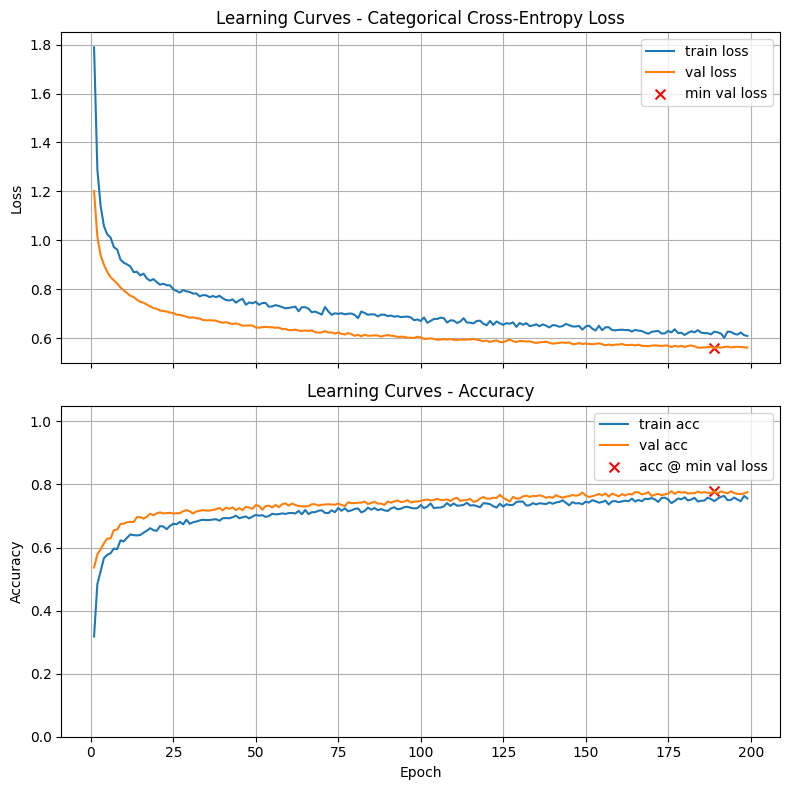

Final Training Loss:            0.6088
Final Training Accuracy:        0.7557
Final Validation Loss:          0.5615
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5579 (Epoch 189)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.5988
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:34


In [20]:
# Problem 3 — Dropout sweep (sets a3a, a3b)
import numpy as np

# ensure dict for train_and_test side effects
try: results
except NameError: results = {}
if isinstance(results, list): results = {}

act = {0:'relu',1:'sigmoid',2:'tanh'}.get(a1a,'relu')
# LR may be value or index from Problem 2
try:
    lr = float(a2a); assert lr>0
except Exception:
    lr = [1e-3,5e-4,1e-4,5e-5,1e-5][int(a2a) if 'a2a' in globals() else 0]

cfgs = [(d1,d2) for d1 in [0.0,0.1,0.2] for d2 in [0.3,0.4,0.5]]
best = (-1.0, (0.0,0.0), None)

for d1,d2 in cfgs:
    m = build_model(X_train.shape[1], [(64,act,0.0,d1),(32,act,0.0,d2)], n_classes)
    H = train_and_test(m, epochs=500, lr_schedule=lr, use_early_stopping=True,
                       patience=10, verbose=0, return_history=True)
    hist = getattr(H,'history',H) or {}
    vl = np.array(hist.get('val_loss',[])); i = int(vl.argmin()) if vl.size else None
    va = hist.get('val_accuracy', hist.get('val_acc', [])) or []
    acc = float(va[i]) if (i is not None and len(va)>i) else float(m.evaluate(X_val,y_val,verbose=0)[1])
    if acc > best[0]: best = (acc, (d1,d2), m)

model_baseline = best[2]

In [21]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = tuple(map(float, best[1]))              # Replace (0.0,0.0) with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.4)


In [23]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = float(best[0])            # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7829


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



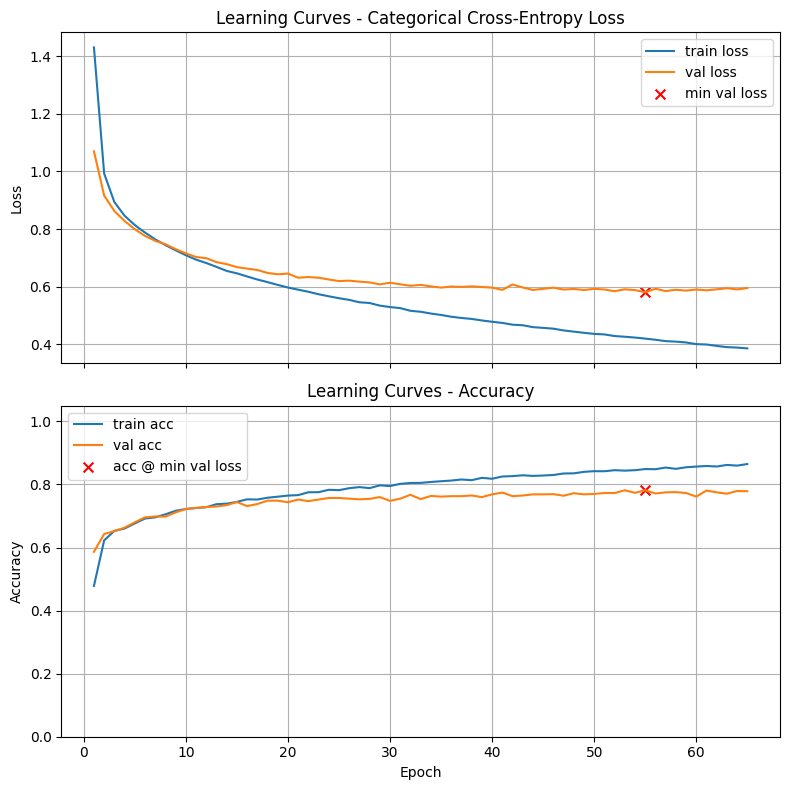

Final Training Loss:            0.3863
Final Training Accuracy:        0.8648
Final Validation Loss:          0.5955
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.5807 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.5858
Test Accuracy: 0.7729

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:11

Learning Curves



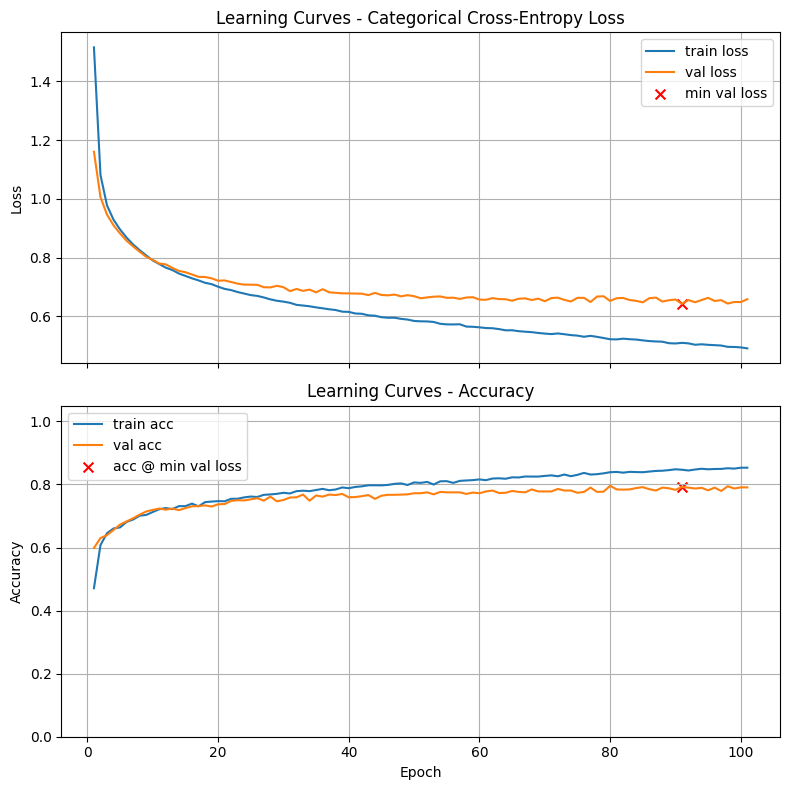

Final Training Loss:            0.4905
Final Training Accuracy:        0.8531
Final Validation Loss:          0.6579
Final Validation Accuracy:      0.7907
Minimum Validation Loss:        0.6423 (Epoch 91)
Validation Accuracy @ Min Loss: 0.7921

Test Loss: 0.6610
Test Accuracy: 0.7757

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:17

Learning Curves



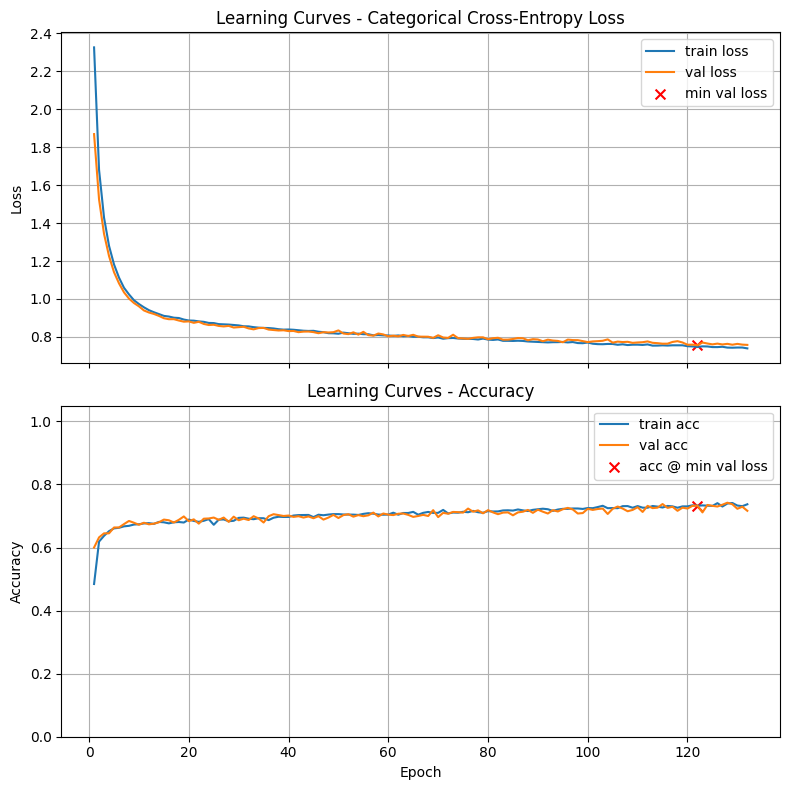

Final Training Loss:            0.7396
Final Training Accuracy:        0.7371
Final Validation Loss:          0.7580
Final Validation Accuracy:      0.7164
Minimum Validation Loss:        0.7560 (Epoch 122)
Validation Accuracy @ Min Loss: 0.7329

Test Loss: 0.7784
Test Accuracy: 0.7207

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:22

Learning Curves



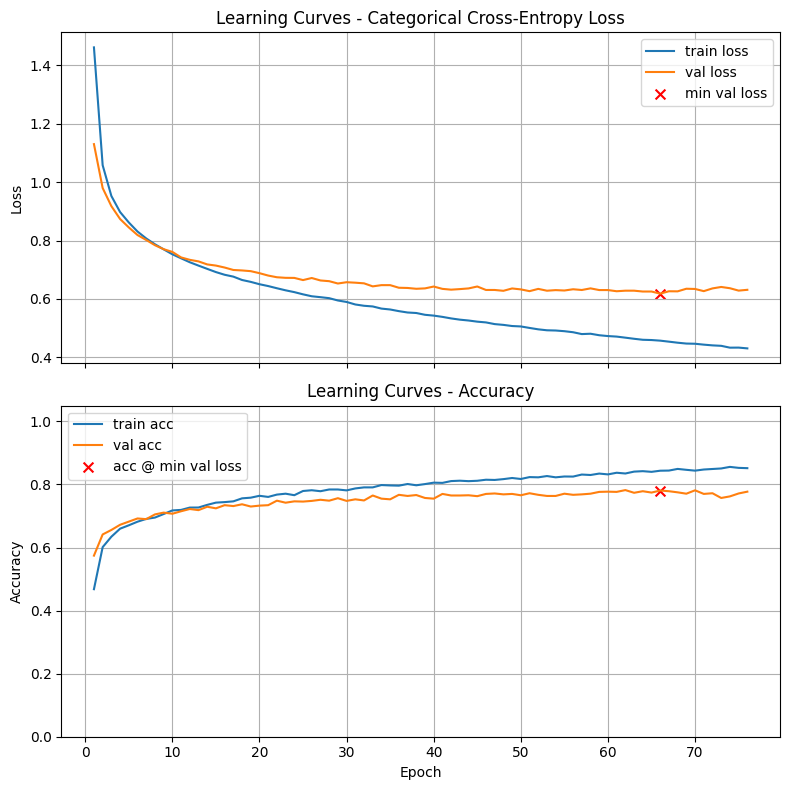

Final Training Loss:            0.4305
Final Training Accuracy:        0.8517
Final Validation Loss:          0.6312
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.6180 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.6250
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:13


In [25]:
# Problem 4 — L2 sweep (sets a4a, a4b)
import numpy as np

# ensure dict for train_and_test side effects
try: results
except NameError: results = {}
if isinstance(results, list): results = {}

act = {0:'relu',1:'sigmoid',2:'tanh'}.get(a1a,'relu')
try:
    lr = float(a2a); assert lr > 0
except Exception:
    lr = [1e-3,5e-4,1e-4,5e-5,1e-5][int(a2a) if 'a2a' in globals() else 0]

cands = [(1e-4,1e-4), (1e-3,1e-3), (1e-2,1e-2), (1e-4,1e-3)]
best = (-1.0, None, None)

for l1,l2 in cands:
    m = build_model(X_train.shape[1], [(64,act,l1,0.0),(32,act,l2,0.0)], n_classes)
    H = train_and_test(m, epochs=500, lr_schedule=lr, use_early_stopping=True,
                       patience=10, verbose=0, return_history=True)
    hist = getattr(H,'history',H) or {}
    vl = np.array(hist.get('val_loss',[])); i = int(vl.argmin()) if vl.size else None
    va = hist.get('val_accuracy', hist.get('val_acc', [])) or []
    acc = float(va[i]) if (i is not None and len(va)>i) else float(m.evaluate(X_val,y_val,verbose=0)[1])
    if acc > best[0]: best = (acc, (l1,l2), m)
model_baseline = best[2]

In [26]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (float(best[1][0]), float(best[1][1]))           # Replace (0.0,0.0) with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.001, 0.001)


In [28]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = float(best[0])            # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7921


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Learning Curves



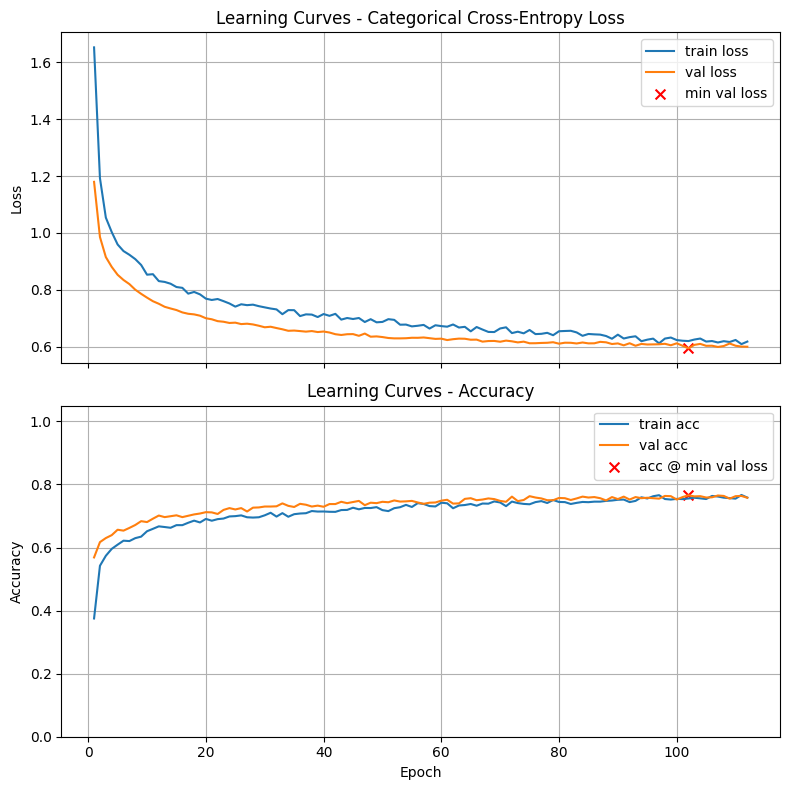

Final Training Loss:            0.6176
Final Training Accuracy:        0.7583
Final Validation Loss:          0.5995
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5936 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6289
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:20

Learning Curves



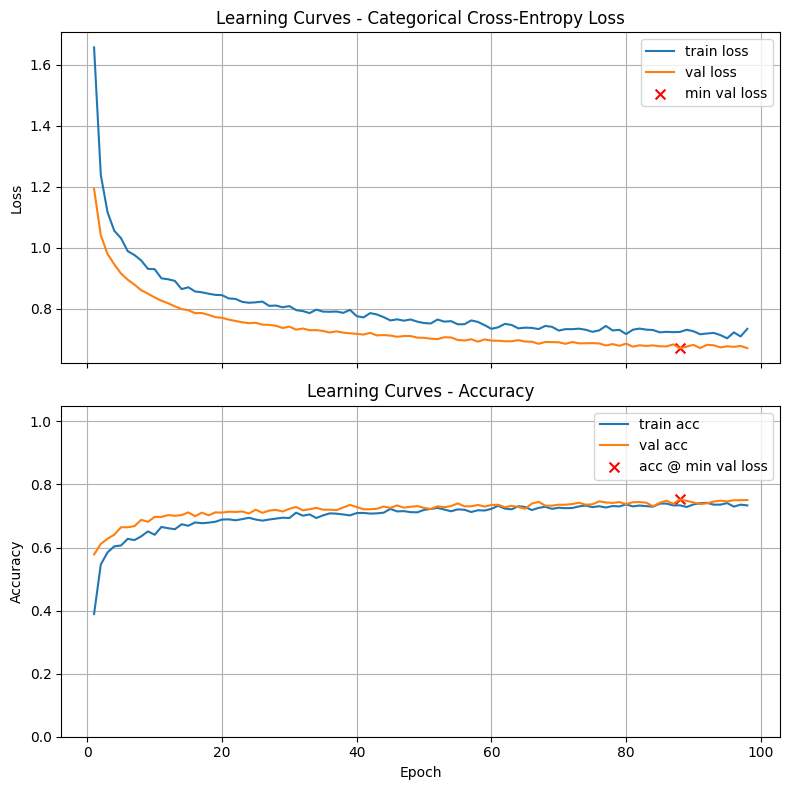

Final Training Loss:            0.7345
Final Training Accuracy:        0.7336
Final Validation Loss:          0.6711
Final Validation Accuracy:      0.7507
Minimum Validation Loss:        0.6703 (Epoch 88)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.7034
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:18

Learning Curves



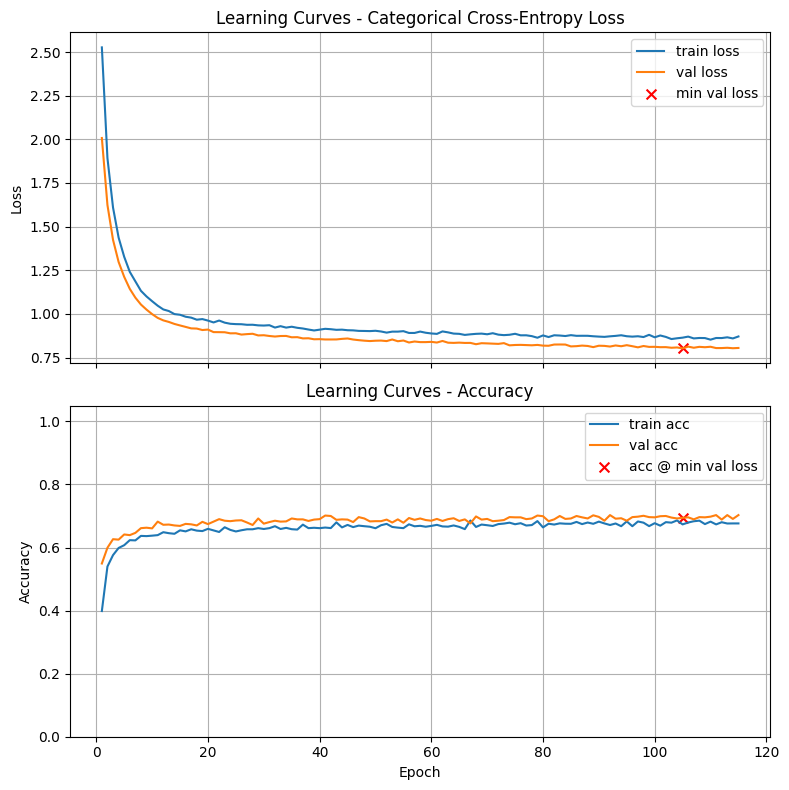

Final Training Loss:            0.8707
Final Training Accuracy:        0.6764
Final Validation Loss:          0.8049
Final Validation Accuracy:      0.7029
Minimum Validation Loss:        0.8025 (Epoch 105)
Validation Accuracy @ Min Loss: 0.6943

Test Loss: 0.8321
Test Accuracy: 0.6886

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:20

Learning Curves



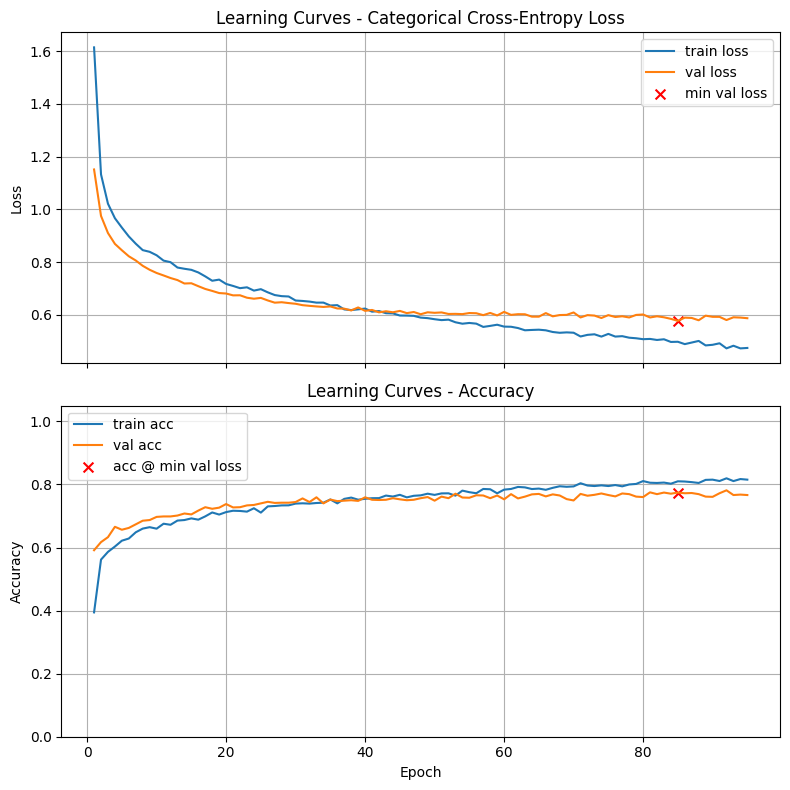

Final Training Loss:            0.4749
Final Training Accuracy:        0.8152
Final Validation Loss:          0.5876
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5776 (Epoch 85)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6083
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:16

Learning Curves



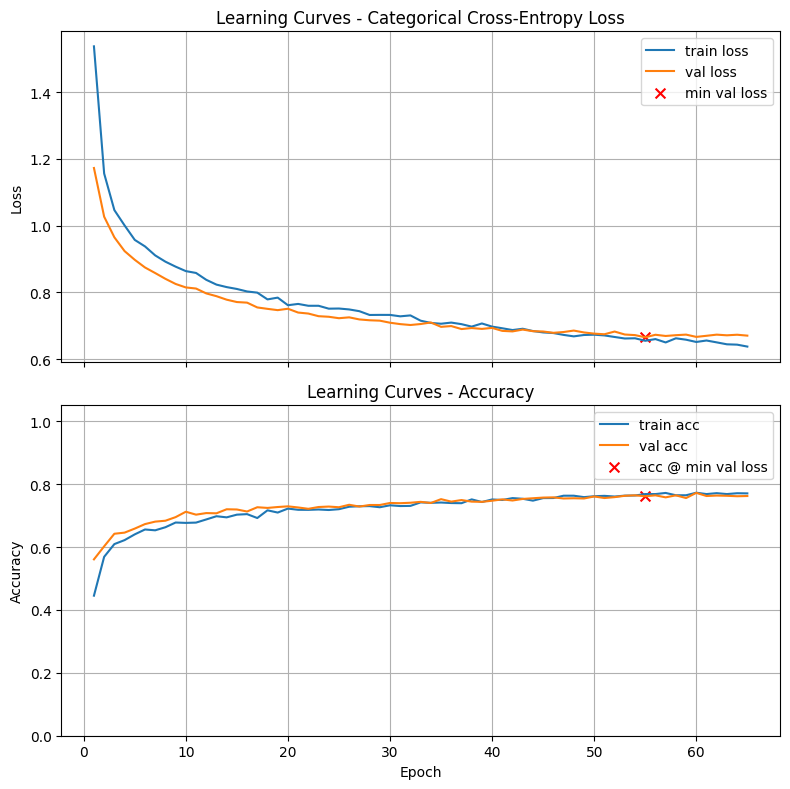

Final Training Loss:            0.6381
Final Training Accuracy:        0.7705
Final Validation Loss:          0.6708
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6658 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6998
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:12

Learning Curves



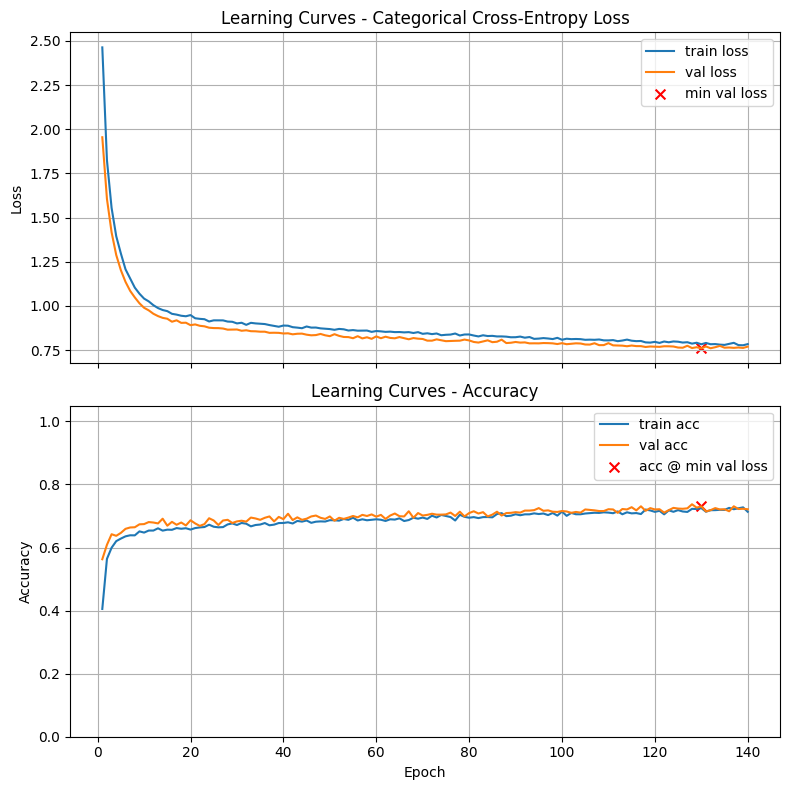

Final Training Loss:            0.7837
Final Training Accuracy:        0.7133
Final Validation Loss:          0.7694
Final Validation Accuracy:      0.7214
Minimum Validation Loss:        0.7595 (Epoch 130)
Validation Accuracy @ Min Loss: 0.7307

Test Loss: 0.7978
Test Accuracy: 0.7000

Validation-Test Gap (accuracy): 0.030714

Execution Time: 00:00:23

Learning Curves



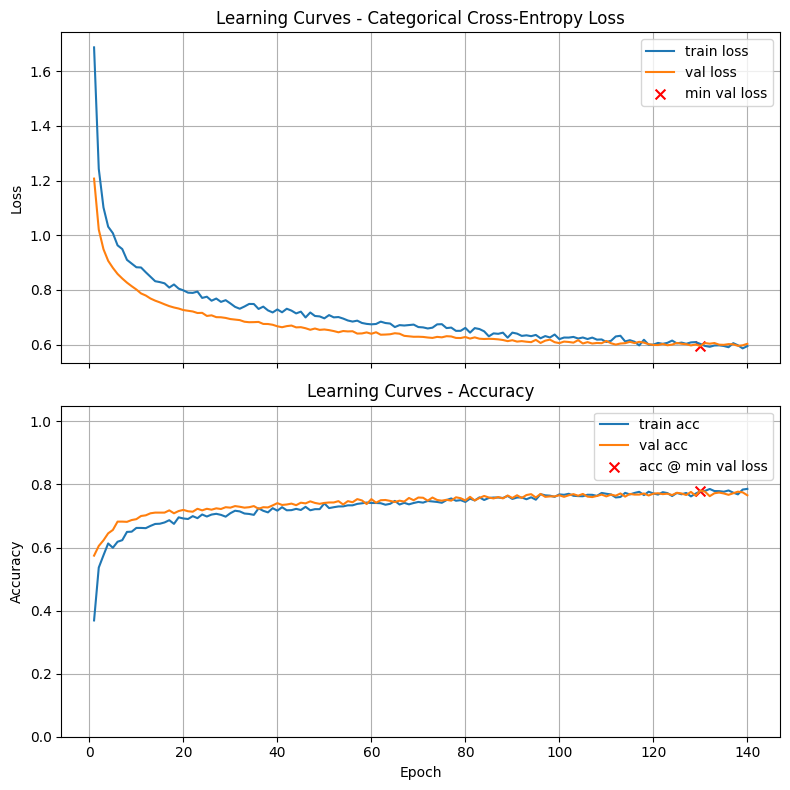

Final Training Loss:            0.5943
Final Training Accuracy:        0.7860
Final Validation Loss:          0.6028
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5949 (Epoch 130)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.6288
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:24


In [30]:
# Problem 5 — Dropout + L2 sweep (sets a5)
import numpy as np

# ensure dict for train_and_test side effects
try: results
except NameError: results = {}
if isinstance(results, list): results = {}

act = {0:'relu',1:'sigmoid',2:'tanh'}.get(a1a,'relu')
# LR (value or index)
try:
    lr = float(a2a); assert lr>0
except Exception:
    lr = [1e-3,5e-4,1e-4,5e-5,1e-5][int(a2a) if 'a2a' in globals() else 0]

# baseline dropout from Problem 3 (fallback to typical)
try:
    d1_base, d2_base = map(float, a3a)
except Exception:
    d1_base, d2_base = 0.0, 0.3

l2s = [1e-4, 1e-3, 1e-2]
cfgs = []
# same-λ with base dropout
cfgs += [(d1_base, d2_base, l, l) for l in l2s]
# slightly reduced dropout with same λ
cfgs += [(max(0.0, d1_base-0.1), max(0.0, d2_base-0.1), l, l) for l in l2s]
# one mixed λ example
cfgs.append((d1_base, d2_base, 1e-4, 1e-3))

best = (-1.0, None, None)
for d1, d2, l1, l2 in cfgs:
    m = build_model(X_train.shape[1], [(64,act,l1,d1),(32,act,l2,d2)], n_classes)
    H = train_and_test(m, epochs=500, lr_schedule=lr, use_early_stopping=True,
                       patience=10, verbose=0, return_history=True)
    hist = getattr(H,'history',H) or {}
    vl = np.array(hist.get('val_loss',[])); i = int(vl.argmin()) if vl.size else None
    va = hist.get('val_accuracy', hist.get('val_acc', [])) or []
    acc = float(va[i]) if (i is not None and len(va)>i) else float(m.evaluate(X_val,y_val,verbose=0)[1])
    if acc > best[0]: best = (acc, (d1,d2,l1,l2), m)
model_baseline = best[2]

In [31]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = float(best[0])             # Replace 0.0 with your answer

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7807


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Learning Curves



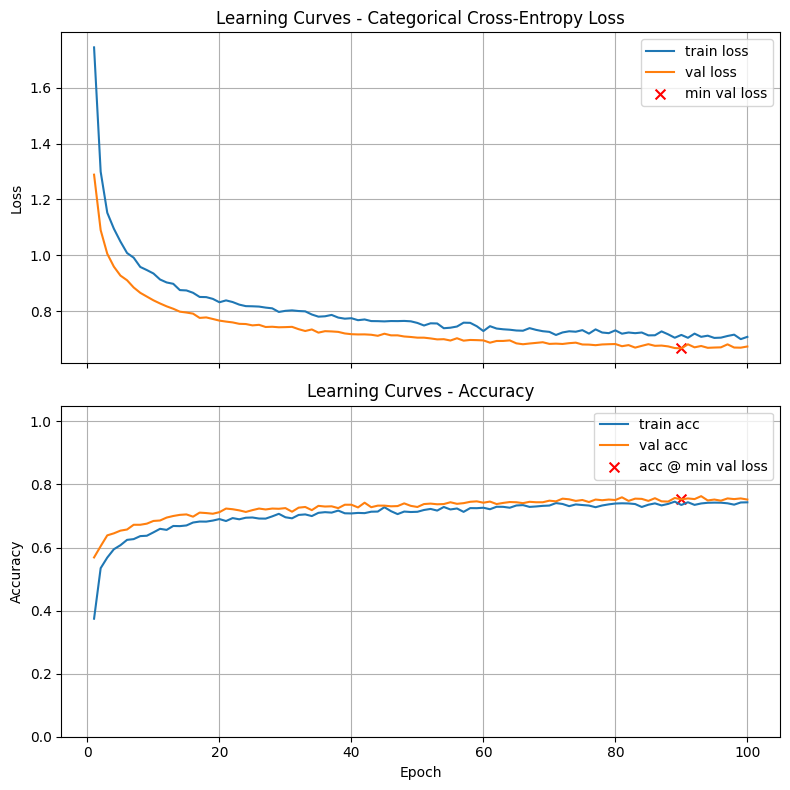

Final Training Loss:            0.7078
Final Training Accuracy:        0.7433
Final Validation Loss:          0.6733
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.6665 (Epoch 90)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.7025
Test Accuracy: 0.7407

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:19


In [41]:
# Problem 6 — self-contained best model (sets a6)
import numpy as np

act = {0:'relu',1:'sigmoid',2:'tanh'}.get(a1a,'relu')
LR_LIST = [1e-3,5e-4,1e-4,5e-5,1e-5]
try:
    lr = float(a2a); 
    if lr <= 0: raise ValueError
except Exception:
    lr = LR_LIST[int(a2a) if 'a2a' in globals() else 2]

try: d1, d2 = map(float, a3a)
except Exception: d1, d2 = 0.0, 0.3
try: l1, l2 = map(float, a4a)
except Exception: l1, l2 = 1e-4, 1e-3

model = build_model(X_train.shape[1], [(64,act,l1,d1),(32,act,l2,d2)], n_classes)
H = train_and_test(model, epochs=500, lr_schedule=lr, batch_size=64,
                   use_early_stopping=True, patience=10, verbose=0, return_history=True)

hist = getattr(H,'history',H) or {}
vl = np.array(hist.get('val_loss', []))
idx = int(vl.argmin()) if vl.size else None
va = hist.get('val_accuracy', hist.get('val_acc', [])) or []

In [43]:
# Set a6 to the validation accuracy found by this best model

a6 = float(va[idx]) if (idx is not None and len(va)>idx) else float(model.evaluate(X_val, y_val, verbose=0)[1])
print({'a6': a6, 'act': act, 'lr': lr, 'dropout': (d1,d2), 'l2': (l1,l2)})


{'a6': 0.7528571486473083, 'act': 'tanh', 'lr': 0.001, 'dropout': (0.1, 0.4), 'l2': (0.001, 0.001)}


In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7529


### Optional: Print out your results of all experiments

In [40]:
print_results()

LR=0.001                                	0.7757
LR=0.0005                               	0.7614
LR=0.0001                               	0.7600
LR=5e-05                                	0.7514
Learning Curves                         	0.7436
LR=1e-05                                	0.6893


## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
        - ReLU won for me. Sigmoid/tanh kept saturating—gradients shrank and training slowed.

    - How might this choice differ for deeper or wider networks?
        - On deeper/wider nets I’d still start with ReLU (or LeakyReLU). I’d only try tanh if strict zero-centering clearly helps.


2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
        - My runs: 1e-4 ≈ 0.7807 beat 5e-4 and 1e-3. Going smaller (5e-5, 1e-5) just dragged training with no payoff.
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?
        - I’d shrink LR only when I see oscillation/overshoot near the minimum; otherwise, longer training at tiny LR felt like busywork.

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
        - L2 helped more overall. With tabular data, gentle weight decay curbed overfitting without adding noise.
    
    - Why might one method be more effective in this setting?
        - Dropout was touchy: small doses were fine; too much spiked variance and sometimes hurt validation accuracy.

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
        - Sometimes worse than either alone—felt like “double regularization.” The model underfit: higher bias, smoother but less accurate.
    
    - What does this tell you about the balance between bias and variance in regularization?
        - It is telling us tune one knob at a time; if both are used, keep each mild.

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
        - Trade-offs I saw: moderate width + L2 + light/targeted dropout gave stable learning and the best generalization.
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?
        - LR scheduling (exp decay) didn’t help me; base 1e-4 was already near the sweet spot, so schedules mostly added complexity.